# Meta Data Maker

In [3]:
import xarray as xr
import numpy as np
import warnings
# import cftime
from importlib import reload
import os, sys
# from glob import glob
import constants
sys.path.append(constants.MODULE_DIR)
import json
# Custom plots for signal to noise functions.
import open_ds
# import xarray_class_accessors as xca
warnings.filterwarnings('ignore')
# import signal_to_noise as sn
# import xarray_extender as xce
import utils
from pprint import pprint
from classes import ExperimentTypes

# Loading Data

In [4]:
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, 'tas', 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped'

In [10]:
fnames_abrupt4x = list(map(os.path.basename, glob(os.path.join(ROOT_DIR, '*abrupt4x*'))))
fnames_control = list(map(os.path.basename, glob(os.path.join(ROOT_DIR, '*control*'))))

# abrupt4x_ds = open_ds.read_and_merge_netcdfs(fnames_abrupt4x, ROOT_DIR)
# abrupt4x_ds
utils.pprint_list(fnames_abrupt4x, num_start_items=5)

# fnames_control = list(map(os.path.basename, glob(os.path.join(ROOT_DIR, '*control*'))))
# control_ds = open_ds.read_and_merge_netcdfs(fnames_control, ROOT_DIR)
# control_ds

lenght = 15
 0. tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025.nc
 1. tas_mon_ECEARTH_abrupt4x_150_g025.nc
 2. tas_ann_HadGEM2_abrupt4x_1299_g025.nc
 3. tas_mon_GISSE2R_abrupt4x_5001_g025.nc
 4. tas_mon_MPIESM12_abrupt4x_999_g025.nc


In [21]:
utils.pprint_list(fnames_control, num_start_items=5)


lenght = 17
 0. tas_ann_HadGEM2_control_239_g025.nc
 1. tas_mon_HadCM3L_control_1000_g025.nc
 2. tas_mon_GFDLCM3_control_5200_g025.nc
 3. tas_mon_CCSM3_control_1530_g025.nc
 4. tas_mon_GISSE2R_control_5225_g025.nc


In [41]:
def get_model(fname):
    return fname.split('_')[2].lower()

In [53]:
control_models = np.sort(list(map(get_model, fnames_control)))
abrupt4x_models = list(map(get_model, fnames_abrupt4x))

control_models

array(['ccsm3', 'cesm104', 'cnrmcm61', 'ecearth', 'echam5mpiom', 'famous',
       'gfdlcm3', 'gfdlcm3', 'gfdlesm2m', 'gfdlesm2m', 'gisse2r',
       'hadcm3l', 'hadgem2', 'ipslcm5a', 'miroc32', 'mpiesm11',
       'mpiesm12'], dtype='<U11')

In [52]:
len(control_models)

17

In [51]:
len(np.unique(control_models))

15

In [43]:
def open_and_rename_model(fname):
    ds = xr.open_dataset(os.path.join(ROOT_DIR, fname), use_cftime=True)
    ds = ds.rename({'tas': get_model(fname)})
    return ds

In [64]:
def add_data_to_dict(fnames):
    model_dict = {}

    for fname in fnames:
        
        model_name = get_model(fname)
        
        if model_name in list(model_dict):
            model_name += '_2'

        ds = open_and_rename_model(fname) 

        model_dict[model_name] = ds
    return model_dict

In [67]:
abrupt4x_models_dict = add_data_to_dict(fnames_abrupt4x)
control_models_dict = add_data_to_dict(fnames_control)

In [72]:
models = list(control_models_dict)

In [82]:
# Getting the lenght of each model
longrunmip_model_lengths = {}
for model in models:
    if model not in list(abrupt4x_models_dict):
        exp_len = len(abrupt4x_models_dict[model.split('_')[0]].dropna(dim='time').time.values)
    else:
        exp_len = len(abrupt4x_models_dict[model].dropna(dim='time').time.values)


    control_len = len(control_models_dict[model].dropna(dim='time').time.values)
    
    if model in list(longrunmip_model_lengths):
        model += '_2'
    longrunmip_model_lengths[model] = {'control': control_len, '4xCO2': exp_len}

    
longrunmip_model_lengths = {key: longrunmip_model_lengths[key]
                            for key in np.sort(list(longrunmip_model_lengths))}
longrunmip_model_lengths

{'ccsm3': {'control': 1530, '4xCO2': 2120},
 'cesm104': {'control': 1000, '4xCO2': 5900},
 'cnrmcm61': {'control': 2000, '4xCO2': 1850},
 'ecearth': {'control': 508, '4xCO2': 150},
 'echam5mpiom': {'control': 100, '4xCO2': 1001},
 'famous': {'control': 3000, '4xCO2': 3000},
 'gfdlcm3': {'control': 5200, '4xCO2': 150},
 'gfdlcm3_2': {'control': 500, '4xCO2': 150},
 'gfdlesm2m': {'control': 1340, '4xCO2': 150},
 'gfdlesm2m_2': {'control': 500, '4xCO2': 150},
 'gisse2r': {'control': 128, '4xCO2': 5001},
 'hadcm3l': {'control': 1000, '4xCO2': 1000},
 'hadgem2': {'control': 239, '4xCO2': 1299},
 'ipslcm5a': {'control': 1000, '4xCO2': 1000},
 'miroc32': {'control': 681, '4xCO2': 150},
 'mpiesm11': {'control': 2000, '4xCO2': 4459},
 'mpiesm12': {'control': 1237, '4xCO2': 1000}}

In [83]:
with open('data/longrunmip_model_lengths.json', 'w') as fp:
    json.dump(longrunmip_model_lengths, fp)

### Sample of opening files using this new method

In [84]:
reload(open_ds)

<module 'open_ds' from '/home/563/ab2313/Documents/PhD/modules/open_ds.py'>

In [85]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [86]:
ROOT_DIR.replace('tas', 'pr')

'/g/data/w40/ab2313/PhD/longrunmip/pr/regrid_retimestamped'

In [87]:
files_to_open = open_ds.get_file_names_from_from_directory(ROOT_DIR.replace('tas', 'pr')
                                                           ,ExperimentTypes.ABRUPT4X, models_to_get)
utils.pprint_list(files_to_open)

lenght = 7
 0. pr_mon_CCSM3_abrupt4x_2120_g025.nc
 1. pr_mon_CESM104_abrupt4x_5900_g025.nc


In [91]:
ds = open_ds.read_and_merge_netcdfs(files_to_open, ROOT_DIR.replace('tas', 'pr'))
ds

- model='cesm104' is too short has time_length=112 < requested_length=800
(fname='pr_mon_CESM104_abrupt4x_5900_g025.nc')


<xarray.Dataset>
Dimensions:   (time: 1200, lon: 144, lat: 72)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables:
    ccsm3     (time, lat, lon) float64 101.1 98.14 98.13 ... 311.8 312.0 312.0
    cnrmcm61  (time, lat, lon) float64 81.63 81.63 81.9 ... 546.6 545.2 545.2
    hadcm3l   (time, lat, lon) float64 21.51 21.15 20.87 20.54 ... nan nan nan
    ipslcm5a  (time, lat, lon) float64 51.19 50.28 50.11 50.1 ... nan nan nan
    mpiesm11  (time, lat, lon) float64 50.58 50.9 51.51 ... 324.1 326.4 330.1
    mpiesm12  (time, lat, lon) float64 42.56 42.69 42.99 43.17 ... nan nan nan
Attributes:
    length:   2120

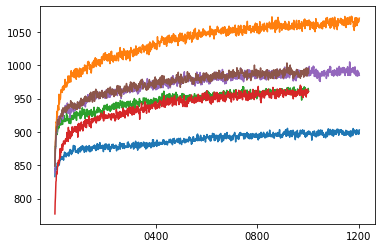

In [92]:
import matplotlib.pyplot as plt
for model in list(ds.data_vars):
    da = ds[model].dropna(dim='time').mean(dim=['lat', 'lon'])
    plt.plot(da.time.values, da.values)

In [93]:
fname='pr_mon_CESM104_abrupt4x_5900_g025.nc'
tds  = xr.open_dataset(os.path.join(ROOT_DIR.replace('tas', 'pr'), fname))

In [94]:
tds

<xarray.Dataset>
Dimensions:  (time: 112, lon: 144, lat: 72)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0112-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables:
    pr       (time, lat, lon) float32 ...